There are two main approaches when summarizing text:

• **Extractive summarization**: Phrases or sentences from the articles are selected
and put together to create a summary. A mental model for this approach
is using a highlighter on the long-form text, and the summary is the
highlights put together. Extractive summarization is a more straightforward
approach as sentences from the source text can be copied, which leads to
fewer grammatical issues. The quality of the summarization is also easier to
measure using metrics such as ROUGE. Extractive summarization was the predominant approach before
deep learning and neural networks.

• **Abstractive summarization [Used in This Notebook]**: A person may use the full vocabulary available
in a language while summarizing an article. They are not restricted to only
using words from the article. The mental model is that the person is penning
a new piece of text. The model must have some understanding of the
meaning of different words so that the model can use them in the summary.
Abstractive summarization is quite hard to implement and evaluate. The
advent of the seq2seq architecture made significant improvements to the
quality of abstractive summarization models.

## Seq2seq model with attention
The summarization model has an Encoder part with a bidirectional RNN and a
unidirectional decoder part. There is an attention layer that helps the Decoder
focus on specific parts of the input while generating an output token. The overall
architecture is shown in the following diagram:

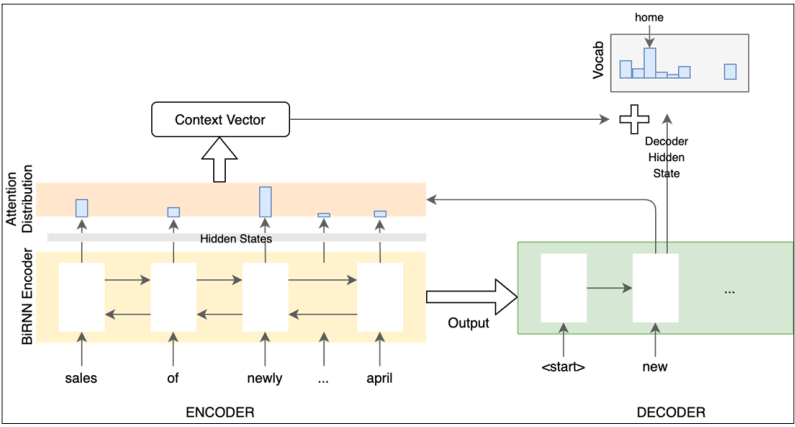


# Import Libs

In [ ]:
!pip install rouge_score

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import GRU, Bidirectional, Dense
import tensorflow_datasets as tfds

import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
import os
import time
from rouge_score import rouge_scorer as rs


# Encoder model


The detailed architecture of the Encoder layer is shown in the following diagram.
Tokenized and vectorized input is fed through an embedding layer. Embeddings for
the tokens generated by the tokenizer are learned from scratch. It is possible to use
a set of pre-trained embeddings like GloVe and use the corresponding tokenizer.
While using a pre-trained set of embeddings can help with the accuracy of the
model, a word-based vocabulary would have many unknown tokens . The unknown tokens would impact
the ability of the model to create summaries with words it hasn't seen before. If the
summarization model is used on daily news, there can be several unknown words,
like names of people, places, or new products

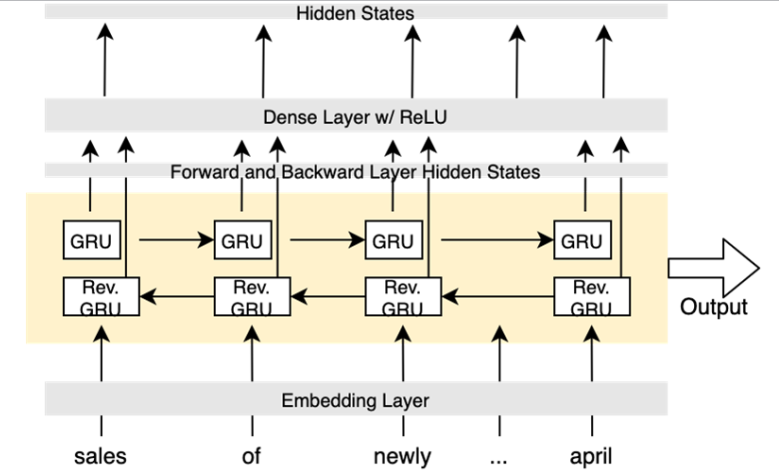

In [ ]:
embedding_dim = 128
units = 256 # from pointer generator paper

class Embedding(object):
  embedding = None #Singleton >   embedding singleton that can be used by both the Encoder and the Decoder

  @classmethod # Call Method from Outside
  def get_embedding(self,vocab_size , embedding_dim):
    if self.embedding is None:
      self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim,mask_zero=True)
    
    return self.embedding

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self,vocab_size, embedding_dim, enc_units, batch_size):
    super(Encoder,self).__init__()
    self.batch_size = batch_size
    self.enc_units = enc_units
    self.embedding = Embedding.get_embedding(vocab_size,embedding_dim)
    self.biGRU = Bidirectional(GRU(enc_units,return_sequences=True,return_state=True, recurrent_initializer='glorot_uniform'),merge_mode='concat' )
    self.relu = Dense(self.enc_units,activation='relu')

  def call(self,x, hidden):
    x = self.embedding(x)
    output, forward_state, backward_state = self.biGRU(x,initial_state = hidden)
    # Concat
    hidden_state = tf.concat([forward_state,backward_state] , axis = 1) 
    output_state = self.relu(hidden_state)

    return output, output_state

  #to return initial hidden state 
  # return 2 for forward and backward state (Bi Directional)
  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_size,self.enc_units)) for _ in range(2)]


# Bahdanau attention layer

The core idea behind attention is to let the Decoder see all the inputs and focus
on the most relevant inputs while predicting the output token. A global attention
mechanism allows the Decoder to see all the inputs. This global version of the
attention mechanism will be implemented. At an abstract level, the purpose of the
attention mechanism maps a set of values to a given query. It does this by providing
a relevance score of each of these values for a given query In our case, the query is the Decoder's hidden state, and the values are the Encoder
outputs. We are interested in figuring out which inputs can best help in generating
the next token from the Decoder. The first step is computing a score using the
Encoder output and the Decoder's previous hidden state. If this is the first step of
decoding, then the hidden states from the Encoder are used to seed the Decoder. A
corresponding weight matrix is multiplied by the Encoder's output and Decoder's
hidden state. The output is passed through a tanh activation function and multiplied
by another weight matrix to produce the final score. The following equation shows
this formulation:
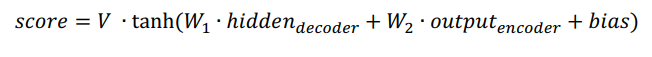

Matrices V, W1, and W2 are trainable. Then, to understand the alignment between the
Decoder output and the Encoder outputs, a softmax is computed:

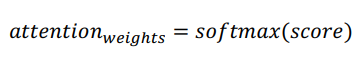


The last step is to produce a context vector. The context vector is produced by
multiplying the attention weights by the Encoder outputs:

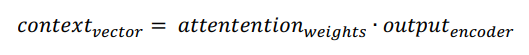

These are all the computations in the attention layer.

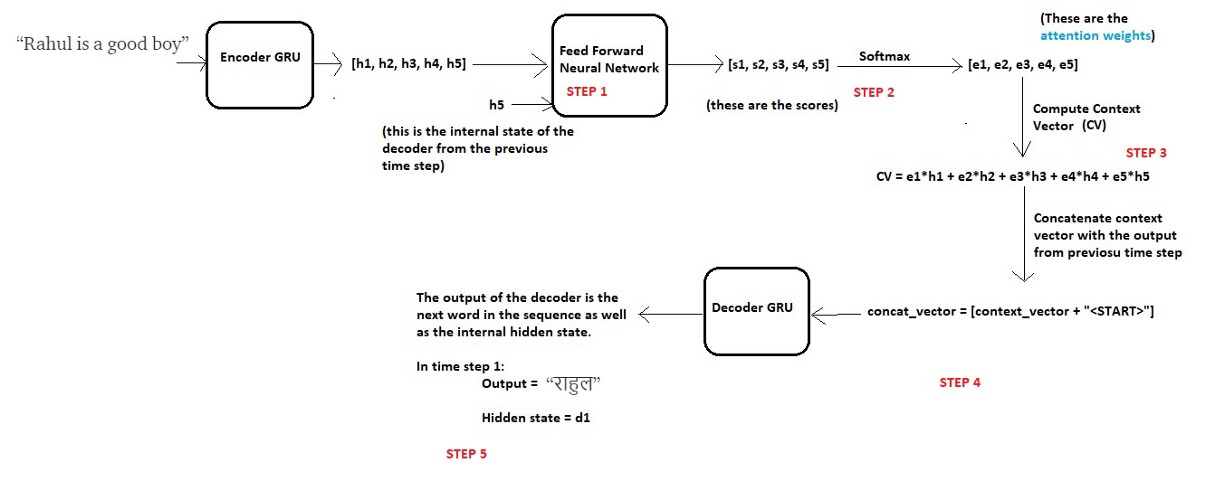

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self,units):
    super(BahdanauAttention,self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self,decoder_hidden,enc_output):
    # decoder hidden state shape == (64, 256)
    # [batch size, decoder units]
    # encoder output shape == (64, 128, 256)
    # which is [batch size, max sequence length, encoder units]

    query = decoder_hidden # maps summarization to generic form of attention
    values = enc_output

    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to broadcast addition along the time axis 
    query_with_time_axis = tf.expand_dims(query,1)

    # score shape == (batch_size, max_length, 1)
    score = self.V(tf.nn.tanh( (self.W1(values) + self.W2(query_with_time_axis) )))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

   # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


# Decoder Model

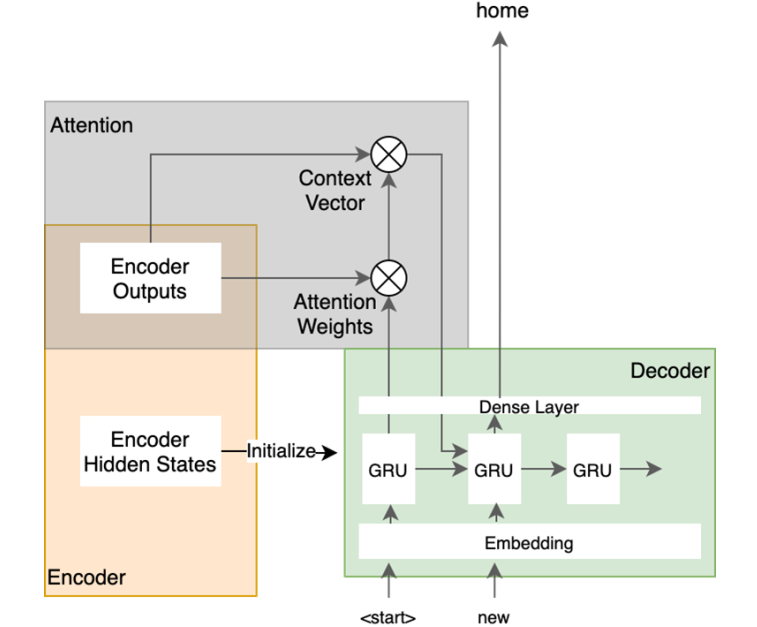

The embedding layer in the Decoder is not shared with the Encoder. This is a
design choice. It is common in summarization to use a shared embedding layer. The
structure of the articles and their summaries is slightly different in the Gigaword
dataset as news headlines are not proper sentences but fragments of sentences.
During training, using different embedding layers gave better results than shared
embeddings. It is possible that, on the CNN/DailyMail dataset, shared embeddings
give better results than on the Gigaword dataset. In the case of machine translation,
the Encoder and Decoder are seeing different languages

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder,self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    # Unique embedding layer
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                              mask_zero=True)
    # Shared embedding layer
    #self.embedding = Embedding.get_embedding(vocab_size, embedding_dim)
    
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(vocab_size, activation='softmax', name='fc1')

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)
  
  def call(self,x, hidden , enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden,enc_output)
    x = self.embedding(x)
    # x shape after concatenation = (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    output = tf.reshape(output, (-1, output.shape[2]))
        
    x = self.fc1(output)
        
    return x, state, attention_weights





In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False, reduction='none')

In [ ]:
#The key to the loss function is to use a mask to handle summaries of varying lengths
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

# Loading The Data

In [ ]:
def load_data():
    print(" Loading the dataset")
    (ds_train, ds_val, ds_test), ds_info = tfds.load(
        'gigaword',
        split=['train', 'validation', 'test'],
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
    )
    return ds_train, ds_val, ds_test

In [ ]:
ds_train, ds_val, ds_test = load_data()

 Loading the dataset


Shuffling and writing examples to /root/tensorflow_datasets/gigaword/1.2.0.incompleteNRV9ZT/gigaword-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/gigaword/1.2.0.incompleteNRV9ZT/gigaword-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/gigaword/1.2.0.incompleteNRV9ZT/gigaword-test.tfrecord


Dataset gigaword downloaded and prepared to /root/tensorflow_datasets/gigaword/1.2.0. Subsequent calls will reuse this data.


In [ ]:
def get_tokenizer(data, file="gigaword32k.enc"):
    if os.path.exists(file+'.subwords'):
        # data has already been tokenized - just load and return
        tokenizer = tfds.deprecated.text.SubwordTextEncoder.load_from_file(file)
    else:
        # This takes a while
        tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
                                ((art.numpy() + b" " + smm.numpy()) for art, smm in data),
                                target_vocab_size=2**15)
        tokenizer.save_to_file(file)  # save for future iterations
    print("Tokenizer ready. Total vocabulary size: ", tokenizer.vocab_size)
    return tokenizer

In [ ]:
tokenizer = get_tokenizer(ds_train)

Tokenizer ready. Total vocabulary size:  32897


In [ ]:
# add start and end of sentence tokens
start = tokenizer.vocab_size + 1 #token no. 32898
end = tokenizer.vocab_size #token no. 32897
vocab_size = end + 2 #vocab inceased by two

In [ ]:
def encode(article, summary, start=start, end=end, tokenizer=tokenizer, 
           art_max_len=128, smry_max_len=50):
    tokens = tokenizer.encode(article.numpy())
    if len(tokens) > art_max_len:
        tokens = tokens[:art_max_len]
    art_enc = sequence.pad_sequences([tokens], padding='post',
                                 maxlen=art_max_len).squeeze()
    
    tokens = [start] + tokenizer.encode(summary.numpy())
    
    if len(tokens) > smry_max_len:
        tokens = tokens[:smry_max_len]
    else:
        tokens = tokens + [end]
    
    smry_enc = sequence.pad_sequences([tokens], padding='post',
                                 maxlen=smry_max_len).squeeze()

    return art_enc, smry_enc


def tf_encode(article, summary):
    art_enc, smry_enc = tf.py_function(encode, [article, summary],
                                     [tf.int64, tf.int64])
    art_enc.set_shape([None])
    smry_enc.set_shape([None])
    return art_enc, smry_enc

In [ ]:
# Test tokenizer
txt = "Coronavirus spread surprised everyone"
print(txt, " => ", tokenizer.encode(txt.lower()))

Coronavirus spread surprised everyone  =>  [16166, 2342, 1980, 7546, 21092]


In [ ]:
len(ds_train) # no of data samples

3803957

In [ ]:
# Limit This Number for faster Training
BUFFER_SIZE = 1000000  # 3500000 takes 7hr/epoch 
BATCH_SIZE = 64  # try bigger batch for faster training

In [ ]:
train = ds_train.take(BUFFER_SIZE)  # .5M samples
print("Dataset sample taken")
train_dataset = train.map(tf_encode) 

Dataset sample taken


In [ ]:
#verify
len(train_dataset)

1000000

In [ ]:
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

# Training Phase

In [ ]:
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE
embedding_dim = 128
units = 256  # from pointer generator paper
EPOCHS = 1

In [ ]:
encoder = Encoder(vocab_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_size, embedding_dim, units, BATCH_SIZE)

In [ ]:
# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                  0.001,
                  decay_steps=steps_per_epoch*(EPOCHS/2),
                  decay_rate=2,
                  staircase=False)

optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [ ]:
dt = datetime.datetime.today().strftime("%Y-%b-%d-%H-%M-%S")
checkpoint_dir = './training_checkpoints-' + dt

In [ ]:
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                  encoder=encoder,
                                  decoder=decoder)

## Custom Train Function

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden, max_gradient_norm=5):
    loss = 0
    
    with tf.GradientTape() as tape:
        # Inside this scope, we call the model (forward pass) and compute the loss
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([start] * BATCH_SIZE, 1)
        
        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            loss += loss_function(targ[:, t], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
            
    batch_loss = (loss / int(targ.shape[1]))
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    # Gradient clipping
    clipped_gradients, _ = tf.clip_by_global_norm(
                                    gradients, max_gradient_norm)
    
    #Finally, we use the optimizer to update the weights of the model based on the gradients
    optimizer.apply_gradients(zip(clipped_gradients, variables))
    return batch_loss

In [ ]:
# We open a for loop that iterates over epochs
for epoch in range(EPOCHS):
        start_tm = time.time()
        enc_hidden = encoder.initialize_hidden_state()
        total_loss = 0
        # For each epoch, we open a for loop that iterates over the dataset, in batches
        for (batch, (art, smry)) in enumerate(train_dataset.take(steps_per_epoch)):
            # For each batch, we open a GradientTape() scope
            batch_loss = train_step(art, smry, enc_hidden) 
            total_loss += batch_loss
            if batch % 100 == 0:
                ts = datetime.datetime.now().strftime("%d-%b-%Y (%H:%M:%S)")
                print('[{}] Epoch {} Batch {} Loss {:.6f}'.format(ts,epoch + 1,
                                                    batch,
                                                    batch_loss.numpy())
                     )
        # saving (checkpoint) the model every %1 epochs
        if (epoch + 1) % 1 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                          total_loss / steps_per_epoch))
        
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start_tm))

[26-Jul-2021 (10:02:48)] Epoch 1 Batch 0 Loss 2.089983
[26-Jul-2021 (10:03:23)] Epoch 1 Batch 100 Loss 1.676062
[26-Jul-2021 (10:03:59)] Epoch 1 Batch 200 Loss 1.595894
[26-Jul-2021 (10:04:35)] Epoch 1 Batch 300 Loss 1.561103
[26-Jul-2021 (10:05:10)] Epoch 1 Batch 400 Loss 1.402507
[26-Jul-2021 (10:05:46)] Epoch 1 Batch 500 Loss 1.387106
[26-Jul-2021 (10:06:22)] Epoch 1 Batch 600 Loss 1.456733
[26-Jul-2021 (10:06:59)] Epoch 1 Batch 700 Loss 1.484644
[26-Jul-2021 (10:07:35)] Epoch 1 Batch 800 Loss 1.372177
[26-Jul-2021 (10:08:11)] Epoch 1 Batch 900 Loss 1.392627
[26-Jul-2021 (10:08:48)] Epoch 1 Batch 1000 Loss 1.458809
[26-Jul-2021 (10:09:24)] Epoch 1 Batch 1100 Loss 1.396939
[26-Jul-2021 (10:10:01)] Epoch 1 Batch 1200 Loss 1.299613
[26-Jul-2021 (10:10:37)] Epoch 1 Batch 1300 Loss 1.356352
[26-Jul-2021 (10:11:13)] Epoch 1 Batch 1400 Loss 1.336896
[26-Jul-2021 (10:11:50)] Epoch 1 Batch 1500 Loss 1.241221
Epoch 1 Loss 1.445503
Time taken for 1 epoch 628.4937791824341 sec



In [ ]:
# function for plotting the attention weights
def plot_attention(attention, article, summary):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    # https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html for scale
    ax.matshow(attention, cmap='cividis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + article, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + summary, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
art_max_len = 128
smry_max_len = 50

def greedy_search(article):
    # To store attention plots of the output
    attention_plot = np.zeros((smry_max_len, art_max_len))

    tokens = tokenizer.encode(article) 
    if len(tokens) > art_max_len:
        tokens = tokens[:art_max_len]

    inputs = sequence.pad_sequences([tokens], padding='post',
                                 maxlen=art_max_len).squeeze()
    inputs = tf.expand_dims(tf.convert_to_tensor(inputs), 0)
    
    # output summary tokens will be stored in this
    summary = ''

    hidden = [tf.zeros((1, units)) for i in range(2)] #BiRNN
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([start], 0)

    for t in range(smry_max_len):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        if predicted_id == end:
            return summary, article, attention_plot
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        summary += tokenizer.decode([predicted_id])
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return summary, article, attention_plot

In [ ]:
# Summarize
def summarize(article, algo='greedy'):
    if algo == 'greedy':
        summary, article, attention_plot = greedy_search(article)
    else:
        print("Algorithm {} not implemented".format(algo))
        return
    
    print('Input: %s' % (article))
    print('** Predicted Summary: {}'.format(summary))

    attention_plot = attention_plot[:len(summary.split(' ')), :len(article.split(' '))]
    plot_attention(attention_plot, article.split(' '), summary.split(' '))

Input: president georgi parvanov summoned france 's ambassador on wednesday in a show of displeasure over comments from french president jacques chirac chiding east european nations for their support of washington on the issue of iraq .
** Predicted Summary: u.s. UNK to the new the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


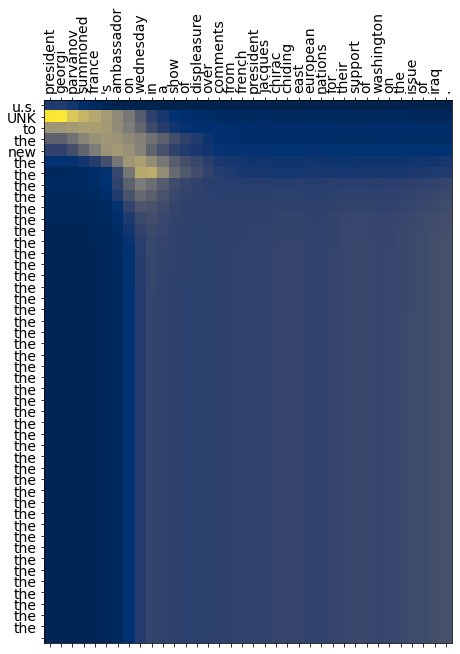

In [ ]:
# Test Summarization
txt = "president georgi parvanov summoned france 's ambassador on wednesday in a show of displeasure over comments from french president jacques chirac chiding east european nations for their support of washington on the issue of iraq ."
summarize(txt.lower())

In [ ]:
# Beam search implementation
def beam_search(article, beam_width=3, 
                         art_max_len=128, 
                         smry_max_len=50,
                         end_tk=end,
                         verbose=True):
    attention_plot = np.zeros((smry_max_len, art_max_len))

    tokens = tokenizer.encode(article)  #no adding start
    if len(tokens) > art_max_len:
        tokens = tokens[:art_max_len]

    inputs = sequence.pad_sequences([tokens], padding='post',
                                 maxlen=art_max_len).squeeze()

    inputs = tf.expand_dims(tf.convert_to_tensor(inputs), 0)
    #print(inputs.shape)

    hidden = [tf.zeros((1, units)) for i in range(2)] #BiRNN
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([start], 0)
    
    # initial beam with (tokens, last hidden state, attn, score)
    start_pt = [([start], dec_hidden, attention_plot, 0.0)]  # initial beam 
    
    for t in range(smry_max_len):
        options = list() # empty list to store candidates
        for row in start_pt:
            # handle beams emitting end signal
            allend = True
            dec_input = row[0][-1]
            if dec_input != end_tk:
                dec_input = tf.expand_dims([dec_input], 0)  # last token
    
                dec_hidden = row[1]  # second item is hidden states
                attn_plt = np.zeros((smry_max_len, art_max_len)) +\
                           row[2] # new attn vector
                
                predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                                 dec_hidden,
                                                                 enc_out)
    
                # storing the attention weights to plot later on
                attention_weights = tf.reshape(attention_weights, (-1, ))
                attn_plt[t] = attention_weights.numpy() 
                
                # take top-K in this beam
                values, indices = tf.math.top_k(predictions[0], k=beam_width)
                for tokid, scre in zip(indices, values):
                    score = row[3] - np.log(scre)
                    options.append((row[0]+[tokid], dec_hidden, attn_plt, score))
                allend=False
            else:
                options.append(row)  # add ended beams back in
        
        if allend:
            break # end for loop as all sequences have ended
    
        start_pt = sorted(options, key=lambda tup:tup[3])[:beam_width]
    
    if verbose:
        # print all the final summaries
        for idx, row in enumerate(start_pt):
            tokens = [x for x in row[0] if x < end_tk]
            print("Summary {} with {:5f}: {}".format(idx, row[3], 
                                          tokenizer.decode(tokens)))
    # return final sequence    
    summary = tokenizer.decode([x for x in start_pt[0][0] if x < end_tk])
    attention_plot = start_pt[0][2]  # third item in tuple
    return summary, article, attention_plot

In [ ]:
# Summarize
def summarize(article, algo='greedy', beam_width=3, verbose=True):
    if algo == 'greedy':
        summary, article, attention_plot = greedy_search(article)
    elif algo=='beam':
        summary, article, attention_plot = beam_search(article, 
                                                    beam_width=beam_width,
                                                    verbose=verbose)
    else:
        print("Algorithm {} not implemented".format(algo))
        return
    
    print('Input: %s' % (article))
    print('** Predicted Summary: {}'.format(summary))

    attention_plot = attention_plot[:len(summary.split(' ')), 
                                    :len(article.split(' '))]
    plot_attention(attention_plot, article.split(' '), 
                   summary.split(' '))

Summary 0 with 11.864101: u.s '.s. 
Summary 1 with 12.605639: u.s '.s '
Summary 2 with 12.926491: u.s '.s
Input: president georgi parvanov summoned france 's ambassador on wednesday in a show of displeasure over comments from french president jacques chirac chiding east european nations for their support of washington on the issue of iraq .
** Predicted Summary: u.s '.s. 


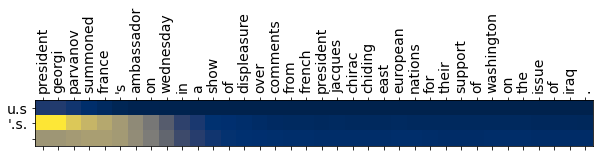

In [ ]:
# Test beam search
txt = "president georgi parvanov summoned france 's ambassador on wednesday in a show of displeasure over comments from french president jacques chirac chiding east european nations for their support of washington on the issue of iraq ."
summarize(txt.lower(), algo='beam', beam_width=3)

In [ ]:
def length_wu(step, score, alpha=0.):
    # NMT length re-ranking score from
    # "Google's Neural Machine Translation System" paper by Wu et al
    modifier = (((5 + step) ** alpha) /
                ((5 + 1) ** alpha))
    return (score / modifier)

In [ ]:
# Beam search implementation with normalization
def beam_search_norm(article, beam_width=3, 
                         art_max_len=128, 
                         smry_max_len=50,
                         end_tk=end,
                         alpha=0.,
                         verbose=True):
    attention_plot = np.zeros((smry_max_len, art_max_len))
    
    tokens = tokenizer.encode(article)  #no adding start
    if len(tokens) > art_max_len:
        tokens = tokens[:art_max_len]

    inputs = sequence.pad_sequences([tokens], padding='post',
                                 maxlen=art_max_len).squeeze()

    inputs = tf.expand_dims(tf.convert_to_tensor(inputs), 0)

    hidden = [tf.zeros((1, units)) for i in range(2)] #BiRNN
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([start], 0)
    
    # (tokens, last hidden state, attn, score)
    start_pt = [([start], dec_hidden, attention_plot, 0.0)]  # initial beam 
    
    for t in range(smry_max_len):
        options = list() # empty list to store candidates
        for row in start_pt:
            # handle beams emitting end signal
            allend = True
            dec_input = row[0][-1]
            if dec_input != end_tk:
                dec_input = tf.expand_dims([dec_input], 0)  # last token

                dec_hidden = row[1]  # second item is hidden states
                attn_plt = np.zeros((smry_max_len, art_max_len)) +\
                               row[2] # new attn vector
                 
                assert id(attn_plt) is not id(row[2]) # new object
                predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                                 dec_hidden,
                                                                 enc_out)

                # check hidden states
                assert id(dec_hidden) is not id(row[1])
                # storing the attention weights to plot later on
                attention_weights = tf.reshape(attention_weights, (-1, ))
                attn_plt[t] = attention_weights.numpy()
                
                # take top-K in this beam
                values, indices = tf.math.top_k(predictions[0], k=beam_width)
                for tokid, scre in zip(indices, values):
                    score = row[3] - np.log(scre) 
                    score = length_wu(t, score, alpha)
                    options.append((row[0]+[tokid], dec_hidden, 
                                    attn_plt, score))
                allend=False
            else:
                options.append(row)
        
        if allend:
            break # end for loop as all sequences have ended

        start_pt = sorted(options, key=lambda tup:tup[3])[:beam_width]
    if verbose:
        # print all the final summaries
        for idx, row in enumerate(start_pt):
            tokens = [x for x in row[0] if x < end_tk]
            print("Summary {} with score {:5f}: {}".format(idx, 
                                          row[3],
                                          tokenizer.decode(tokens)))

    # return final sequence    
    summary = tokenizer.decode([x for x in start_pt[0][0] if x < end_tk])
    attention_plot = start_pt[0][2]  # third item in tuple
    return summary, article, attention_plot

In [ ]:
# Summarize
def summarize(article, algo='greedy', beam_width=3, alpha=0., 
              verbose=True):
    if algo == 'greedy':
        summary, article, attention_plot = greedy_search(article)
    elif algo=='beam':
        summary, article, attention_plot = beam_search(article, 
                                                    beam_width=beam_width,
                                                    verbose=verbose)
    elif algo=='beam-norm':
        summary, article, attention_plot = beam_search_norm(article, 
                                                    beam_width=beam_width,
                                                    alpha=alpha,
                                                    verbose=verbose)
    else:
        print("Algorithm {} not implemented".format(algo))
        return
    if verbose:
        print('Input: %s' % (article))
        print('** Predicted Summary: {}'.format(summary))

        attention_plot = attention_plot[:len(summary.split(' ')), :len(article.split(' '))]
        plot_attention(attention_plot, article.split(' '), summary.split(' '))
    return summary

Summary 0 with score 267.711348: UNK to UNK to new the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
Input: american airlines group inc said on sunday it plans to raise ## billion by selling shares and convertible senior notes , to improve the airline ’s liquidity as it grapples with travel restrictions caused by the coronavirus .
** Predicted Summary: UNK to UNK to new the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


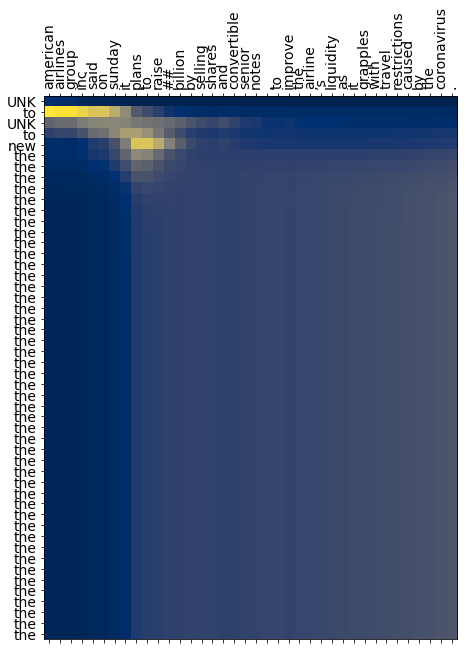

Summary 0 with score 22.953819: u.s '.s '.s '.s
Summary 1 with score 23.959362: u.s '.s '.s 's UNK 
Summary 2 with score 24.166228: u.s '.s '.s '.
Input: american airlines group inc said on sunday it plans to raise ## billion by selling shares and convertible senior notes , to improve the airline ’s liquidity as it grapples with travel restrictions caused by the coronavirus .
** Predicted Summary: u.s '.s '.s '.s


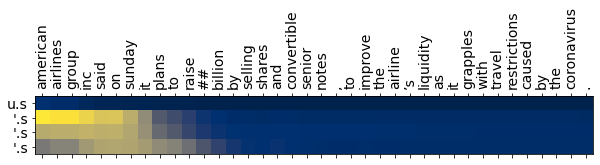

Summary 0 with score 4.093789: u.s '.s '.s
Summary 1 with score 5.092843: u.s '.s '. 
Summary 2 with score 5.118935: u.s '.s '.
Input: american airlines group inc said on sunday it plans to raise ## billion by selling shares and convertible senior notes , to improve the airline ’s liquidity as it grapples with travel restrictions caused by the coronavirus .
** Predicted Summary: u.s '.s '.s


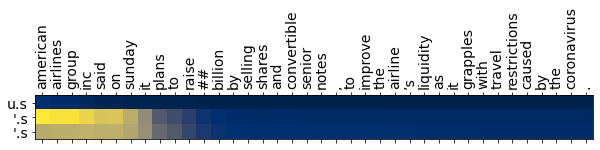

"u.s '.s '.s"

In [ ]:

txt = "American Airlines Group Inc said on Sunday it plans to raise ## billion by selling shares and convertible senior notes , to improve the airline ’s liquidity as it grapples with travel restrictions caused by the coronavirus ."
summarize(txt.lower(), algo='beam-norm', beam_width=1)
summarize(txt.lower(), algo='beam-norm', beam_width=3)
summarize(txt.lower(), algo='beam-norm', beam_width=3, alpha=0.6)

ModuleNotFoundError: ignored

In [ ]:
scorer = rs.RougeScorer(['rougeL'], use_stemmer=True)


In [ ]:
# Summarize
def summarize_quietly(article, algo='greedy', beam_width=3, 
                      alpha=0., verbose=False):
    if algo == 'greedy':
        summary, article, attention_plot = greedy_search(article)
    elif algo=='beam':
        summary, article, attention_plot = beam_search(article, 
                                                    beam_width=beam_width)
    elif algo=='beam-norm':
        summary, article, attention_plot = beam_search_norm(article, 
                                                    beam_width=beam_width,
                                                    alpha=alpha,
                                                    verbose=verbose)
    else:
        print("Algorithm {} not implemented".format(algo))
        return
    
    return summary

In [ ]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
        'gigaword',
        split=['train', 'validation', 'test'],
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
    )

In [ ]:
# total eval size: 189651
articles = 1000
f1 = 0.
prec = 0.
rec = 0.
beam_width = 1

for art, smm in ds_val.take(articles):
    summ = summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=1, verbose=False)
    score = scorer.score(str(smm.numpy()), summ)
    f1 += score['rougeL'].fmeasure / articles
    prec += score['rougeL'].precision / articles
    rec += score['rougeL'].recall / articles
    # see if a sample needs to be printed
    if random.choices((True, False), [1, 99])[0] is True: #1% samples printed out
        print("Article: ", art.numpy())
        print("Ground Truth: ", smm.numpy())
        print("Greedy Summary: ", summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=1, verbose=False))
        print("Beam Search Summary :", summ, "\n")

print("Precision: {:.6f}, Recall: {:.6f}, F1-Score: {:.6f}".format(prec, rec, f1))

Article:  b"shareholders in northern rock lost their second legal challenge on tuesday over the government 's plan to compensate them after nationalizing the mortgage lender ."
Ground Truth:  b'northern rock shareholders lose legal challenge'
Greedy Summary:  UNK to new the new the new the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
Beam Search Summary : UNK to new the new the new the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the  



Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fdbb19dc4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


KeyboardInterrupt: ignored

In [ ]:
# With Beam size of 3
# total eval size: 189651
articles = 1000
f1 = 0.
prec = 0.
rec = 0.

for art, smm in ds_val.take(articles):
    summ = summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=3, verbose=False)
    score = scorer.score(str(smm.numpy()), summ)
    f1 += score['rougeL'].fmeasure / articles
    prec += score['rougeL'].precision / articles
    rec += score['rougeL'].recall / articles
    # see if a sample needs to be printed
    if random.choices((True, False), [1, 99])[0] is True: #1%
        print("Article: ", art.numpy())
        print("Ground Truth: ", smm.numpy())
        print("Greedy Summary: ", summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=1, verbose=False))
        print("Beam Search Summary :", summ, "\n")

print("Precision: {:.6f}, Recall: {:.6f}, F1-Score: {:.6f}".format(prec, rec, f1))

In [ ]:
# Beam size of 3, alpha of 0.4
# total eval size: 189651
articles = 1000
f1 = 0.
prec = 0.
rec = 0.

for art, smm in ds_val.take(articles):
    summ = summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=3, alpha=0.4,
                             verbose=False)
    score = scorer.score(str(smm.numpy()), summ)
    f1 += score['rougeL'].fmeasure / articles
    prec += score['rougeL'].precision / articles
    rec += score['rougeL'].recall / articles
    # see if a sample needs to be printed
    if random.choices((True, False), [1, 99])[0] is True: #1%
        print("Article: ", art.numpy())
        print("Ground Truth: ", smm.numpy())
        print("Greedy Summary: ", summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=1, verbose=False))
        print("Beam Search Summary w/ Length Norm :", summ, "\n")

print("Precision: {:.6f}, Recall: {:.6f}, F1-Score: {:.6f}".format(prec, rec, f1))